In [ ]:
# !pip uninstall torch -y

# Clonar el proyecto
*Nota: Asegurarse de estar trabajando con la GPU.*

In [1]:
!git clone https://github.com/gangweix/Fast-ACVNet.git
%cd Fast-ACVNet

Cloning into 'Fast-ACVNet-ImgProj'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 247 (delta 49), reused 64 (delta 32), pack-reused 152 (from 1)
Receiving objects: 100% (247/247), 101.37 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (70/70), done.
/content/Fast-ACVNet-ImgProj


# Instalar dependencias necesarias

In [2]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install opencv-python
!pip install scikit-image
!pip install tensorboard
!pip install matplotlib
!pip install tqdm
!pip install timm==0.5.4

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 881.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

# Código

In [3]:
#@title Montar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
#@title Funciones necesarias
from PIL import Image
import numpy as np
import cv2
from PIL import Image

def normalize(img):
    image = ((img - img.min()) / (img.max() - img.min())) * 255.0
    return image.astype(np.uint8)

def intensity_binding(img, lower_percentile:int=1, upper_percentile:int=99):
    # Calcular los percentiles
    low = np.percentile(img, lower_percentile)
    high = np.percentile(img, upper_percentile)

    # Recortar al rango [low, high]
    img_clipped = np.clip(img, low, high)

    img_norm = normalize(img_clipped)

    return img_norm

def apply_CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def bilateral_filtering(img):
    return cv2.bilateralFilter(img, d=5, sigmaColor=15, sigmaSpace=3)

def align_contrast(imgL, imgR):
    meanL = np.mean(imgL)
    meanR = np.mean(imgR)

    if meanR < meanL:
      imageR = imgR * (meanL/meanR)
      return imgL, imageR
    elif meanL < meanR:
      imageL = imgL * (meanR/meanL)
      return imageL, imgR

    return imgL, imgR

def preprocess_thermal_image(img):
    if np.max(img) < 35000:
      image = normalize(img)
    else:
      # Eliminar outlayers
      image = intensity_binding(img)

    # Ecualizacion del histograma con clahe
    image = apply_CLAHE(image)

    # Eliminacion de ruido
    image = bilateral_filtering(image)

    return image.astype(np.uint8)

def preprocess_images(imgL, imgR):
    imageL = preprocess_thermal_image(imgL)
    imageR = preprocess_thermal_image(imgR)

    imageL, imageR = align_contrast(imageL, imageR)

    return Image.fromarray(imageL.astype(np.uint8)), Image.fromarray(imageR.astype(np.uint8))

def depth_to_disparity(depth, focal_length = 406.33233091474426, baseline = 0.2458492526627874):
    # Evitar división por cero
    depth = np.clip(depth, a_min=1e-6, a_max=None)
    disparity = (focal_length * baseline) / depth
    return disparity

In [33]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import cv2
import random
import torchvision.transforms as transforms

class ThermalStereoDataset(Dataset):
    def __init__(self, root_dir, domain='frick_2', split='train', training=True, crop_size=(512, 256)):
        self.training = training
        self.crop_w, self.crop_h = crop_size
        self.left_dir = os.path.join(root_dir, domain, split, 'img_left')
        self.right_dir = os.path.join(root_dir, domain, split, 'img_right')
        self.disp_dir = os.path.join(root_dir, domain, split, 'depth_filtered')

        self.left_images = sorted(os.listdir(self.left_dir))
        self.right_images = sorted(os.listdir(self.right_dir))
        self.disp_images = sorted(os.listdir(self.disp_dir))

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def replicate_to_3_channels(self, img):
        img_np = np.array(img)
        if img_np.ndim == 2:
            img_np = np.stack([img_np]*3, axis=-1)
        return Image.fromarray(img_np.astype(np.uint8))

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        # Cargar imágenes
        left_path = os.path.join(self.left_dir, self.left_images[idx])
        right_path = os.path.join(self.right_dir, self.right_images[idx])
        depth_path = os.path.join(self.disp_dir, self.disp_images[idx])

        left_img = cv2.imread(left_path, cv2.IMREAD_UNCHANGED)
        right_img = cv2.imread(right_path, cv2.IMREAD_UNCHANGED)
        depth = np.array(Image.open(depth_path)).astype(np.float32) / 1000.0

        # Aplicar procesado a las imagenes
        left_img, right_img = preprocess_images(left_img, right_img)

        # Calcular el mapa de disparidad
        disparity = depth_to_disparity(depth)

        # Gradiente
        left_np = np.array(left_img)
        dx = cv2.Sobel(left_np, cv2.CV_32F, 1, 0, ksize=3)
        dy = cv2.Sobel(left_np, cv2.CV_32F, 0, 1, ksize=3)
        dxy = np.sqrt(dx**2 + dy**2)
        dxy = dxy / (np.max(dxy) + 1e-5)

        # Replicar a 3 canales
        left_img = self.replicate_to_3_channels(left_img)
        right_img = self.replicate_to_3_channels(right_img)

        if self.training:
            w, h = left_img.size
            x1 = random.randint(0, w - self.crop_w)
            y1 = random.randint(0, h - self.crop_h)

            # Crop
            left_img = left_img.crop((x1, y1, x1 + self.crop_w, y1 + self.crop_h))
            right_img = right_img.crop((x1, y1, x1 + self.crop_w, y1 + self.crop_h))
            disparity = disparity[y1:y1 + self.crop_h, x1:x1 + self.crop_w]
            gradient_map = dxy[y1:y1 + self.crop_h, x1:x1 + self.crop_w]

            # Disparidad downsampled
            disparity_low = cv2.resize(disparity, (self.crop_w//4, self.crop_h//4), interpolation=cv2.INTER_NEAREST)
            disparity_low_r8 = cv2.resize(disparity, (self.crop_w//8, self.crop_h//8), interpolation=cv2.INTER_NEAREST)

            # Aplicar transformaciones
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
            disparity = torch.from_numpy(disparity).float()
            gradient_map = torch.from_numpy(gradient_map).float()
            disparity_low = torch.from_numpy(disparity_low).float()
            disparity_low_r8 = torch.from_numpy(disparity_low_r8).float()

            return {
                "left": left_img,
                "right": right_img,
                "disparity": disparity,
                "gradient_map": gradient_map,
                "disparity_low": disparity_low,
                "disparity_low_r8": disparity_low_r8}

        else:
          w, h = left_img.size
          crop_w, crop_h = 640, 512

          left_img = left_img.crop((w - crop_w, h - crop_h, w, h))
          right_img = right_img.crop((w - crop_w, h - crop_h, w, h))
          disparity = disparity[h - crop_h:h, w - crop_w: w]
          gradient_map = dxy[h - crop_h:h, w - crop_w: w]
          disparity_low = cv2.resize(disparity, (crop_w//4, crop_h//4), interpolation=cv2.INTER_NEAREST)

          left_img = self.transform(left_img)
          right_img = self.transform(right_img)
          disparity = torch.from_numpy(disparity).float()
          gradient_map = torch.from_numpy(gradient_map).float()
          disparity_low = torch.from_numpy(disparity_low).float()

          return {"left": left_img,
                  "right": right_img,
                  "disparity": disparity,
                  "top_pad": 0,
                  "right_pad": 0,
                  "gradient_map":gradient_map,
                  "disparity_low":disparity_low}

In [52]:
import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import time
from models import __models__, model_loss_train, model_loss_test
from utils import *
from torch.utils.data import DataLoader
import gc
import cv2

# Optimizzar el funcionamiento de la GPU
cudnn.benchmark = True

# Establecer una semilla para reproducibilidad
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# model, optimizer
model = __models__['Fast_ACVNet'](192, False)
model = nn.DataParallel(model)
model.cuda()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# # Comprobar si hay capas congeladas
# for name, param in model.named_parameters():
#     print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

In [57]:
# Cargar el generalizado
ckpt_path = '/content/drive/MyDrive/Procesamiento de imagenes/Proyecto Final/checkpoints_max_nofreezing/checkpoint_max_nofreezing_f1f2h22h3h4_e9.ckpt'
if ckpt_path is not None:
    print("loading model {}".format(ckpt_path))
    state_dict = torch.load(ckpt_path)
    model_dict = model.state_dict()
    pre_dict = {k: v for k, v in state_dict['model'].items() if k in model_dict}
    model_dict.update(pre_dict)
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(state_dict['optimizer']) # Cargar el estado del optimizador, si se desea continuar con el entrenamiento

# # Congelar capas
# # Nombres de módulos que quieres entrenar
# trainable_prefixes = [
#     "module.hourglass_att",
#     "module.hourglass",
#     "module.concat_stem"
#     #"module.spx"
# ]

# # Función para verificar si un parámetro debe entrenarse
# def is_trainable(name):
#     return any(name.startswith(p) for p in trainable_prefixes)

# # Aplicar freezing
# for name, param in model.named_parameters():
#     param.requires_grad = is_trainable(name)

# Comprobar si hay capas congeladas
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

loading model /content/drive/MyDrive/Procesamiento de imagenes/Proyecto Final/checkpoints_max_nofreezing/checkpoint_max_nofreezing_f1f2h22h3h4_e9.ckpt
Layer: module.gamma, Requires Gradient: True
Layer: module.beta, Requires Gradient: True
Layer: module.feature.conv_stem.weight, Requires Gradient: True
Layer: module.feature.bn1.weight, Requires Gradient: True
Layer: module.feature.bn1.bias, Requires Gradient: True
Layer: module.feature.block0.0.0.conv_dw.weight, Requires Gradient: True
Layer: module.feature.block0.0.0.bn1.weight, Requires Gradient: True
Layer: module.feature.block0.0.0.bn1.bias, Requires Gradient: True
Layer: module.feature.block0.0.0.conv_pw.weight, Requires Gradient: True
Layer: module.feature.block0.0.0.bn2.weight, Requires Gradient: True
Layer: module.feature.block0.0.0.bn2.bias, Requires Gradient: True
Layer: module.feature.block1.0.0.conv_pw.weight, Requires Gradient: True
Layer: module.feature.block1.0.0.bn1.weight, Requires Gradient: True
Layer: module.feature.

In [54]:
metrics = []

In [59]:
# Carga de datos
from torch.utils.data import ConcatDataset, DataLoader

# Dataset de entrenamiento
dataset_hawkins2 = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='hawkins_2_2', split='train')
dataset_hawkins3 = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='hawkins_3', split='train')
dataset_hawkins4 = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='hawkins_4', split='train')
dataset_frick2 = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='frick_2', split='train')
dataset_frick1 = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='frick_1', split='train')
combined_dataset = ConcatDataset([dataset_hawkins2, dataset_hawkins3, dataset_hawkins4, dataset_frick2, dataset_frick1])
train_loader = DataLoader(combined_dataset, batch_size=10, shuffle=True, num_workers=10)

# Dataset validacion
dataset_hawkins3_val = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='hawkins_3', split='val', training=False)
dataset_hawkins4_val = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='hawkins_4', split='val', training=False)
dataset_frick2_val = ThermalStereoDataset(root_dir='/content/drive/MyDrive/dataset_haw', domain='frick_2', split='val', training=False)
combined_dataset_val = ConcatDataset([dataset_hawkins3_val, dataset_hawkins4_val, dataset_frick2_val])
val_loader = DataLoader(combined_dataset_val, batch_size=10, shuffle=False, num_workers=10)

# Cargar parametros
start_epoch = 10
epochs = 24
checkpoints_path = '/content/drive/MyDrive/Procesamiento de imagenes/Proyecto Final/checkpoints_max_nofreezing'
def train():
    for epoch_idx in range(start_epoch, epochs+1):

        # training
        for batch_idx, sample in enumerate(train_loader):
            start_time = time.time()
            loss = train_sample(sample)
            print('Epoch {}/{}, Iter {}/{}, train loss = {:.3f}, time = {:.3f}'.format(epoch_idx, epochs,
                                                                                       batch_idx,
                                                                                       len(train_loader), loss,
                                                                                       time.time() - start_time))


        # Save the checkpoint
        checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(checkpoint_data, "{}/checkpoint_max_nofreezing_f1f2h22h3h4_e{}.ckpt".format(checkpoints_path, epoch_idx))
        gc.collect()

        # # testing
        avg_test_scalars = AverageMeterDict()
        for batch_idx, sample in enumerate(val_loader):
            start_time = time.time()
            loss, scalar_outputs = test_sample(sample)
            avg_test_scalars.update(scalar_outputs)

            del scalar_outputs
            print('Epoch {}/{}, Iter {}/{}, test loss = {:.3f}, time = {:3f}'.format(epoch_idx, epochs,
                                                                                     batch_idx,
                                                                                     len(val_loader), loss,
                                                                                     time.time() - start_time))
        avg_test_scalars = avg_test_scalars.mean()
        metrics.append(avg_test_scalars)
        print("avg_test_scalars", avg_test_scalars)
        gc.collect()


# train one sample
def train_sample(sample):
    model.train()
    imgL, imgR, disp_gt, disp_gt_low = sample['left'], sample['right'], sample['disparity'], sample['disparity_low']
    imgL = imgL.cuda()
    imgR = imgR.cuda()
    disp_gt = disp_gt.cuda()
    disp_gt_low = disp_gt_low.cuda()
    optimizer.zero_grad()
    disp_ests = model(imgL, imgR)
    mask = (disp_gt < 192) & (disp_gt > 0)
    mask_low = (disp_gt_low < 192) & (disp_gt_low > 0)
    masks = [mask, mask_low, mask, mask_low]
    disp_gts = [disp_gt, disp_gt_low, disp_gt, disp_gt_low]
    loss = model_loss_train(disp_ests, disp_gts, masks)
    loss.backward()
    optimizer.step()

    return tensor2float(loss)

# test one sample
@make_nograd_func
def test_sample(sample):
    model.eval()
    imgL, imgR, disp_gt = sample['left'], sample['right'], sample['disparity']
    imgL = imgL.cuda()
    imgR = imgR.cuda()
    disp_gt = disp_gt.cuda()
    mask = (disp_gt < 192) & (disp_gt > 0)
    disp_ests = model(imgL, imgR)
    disp_gts = [disp_gt]
    masks = [mask]
    loss = model_loss_test(disp_ests, disp_gts, masks)

    scalar_outputs = {"loss": loss}
    scalar_outputs["D1"] = [D1_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
    scalar_outputs["EPE"] = [EPE_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
    scalar_outputs["Thres1"] = [Thres_metric(disp_est, disp_gt, mask, 1.0) for disp_est in disp_ests]
    scalar_outputs["Thres2"] = [Thres_metric(disp_est, disp_gt, mask, 2.0) for disp_est in disp_ests]
    scalar_outputs["Thres3"] = [Thres_metric(disp_est, disp_gt, mask, 3.0) for disp_est in disp_ests]

    return tensor2float(loss), tensor2float(scalar_outputs)

if __name__ == '__main__':
    train()

Streaming output truncated to the last 5000 lines.
Epoch 10/24, Iter 294/1229, train loss = 7.865, time = 0.802
Epoch 10/24, Iter 295/1229, train loss = 8.994, time = 0.790
Epoch 10/24, Iter 296/1229, train loss = 9.190, time = 0.787
Epoch 10/24, Iter 297/1229, train loss = 7.066, time = 0.889
Epoch 10/24, Iter 298/1229, train loss = 9.272, time = 0.790
Epoch 10/24, Iter 299/1229, train loss = 13.759, time = 0.789
Epoch 10/24, Iter 300/1229, train loss = 8.949, time = 0.746
Epoch 10/24, Iter 301/1229, train loss = 13.243, time = 0.790
Epoch 10/24, Iter 302/1229, train loss = 7.045, time = 0.760
Epoch 10/24, Iter 303/1229, train loss = 7.741, time = 0.763
Epoch 10/24, Iter 304/1229, train loss = 10.804, time = 0.743
Epoch 10/24, Iter 305/1229, train loss = 9.695, time = 0.750
Epoch 10/24, Iter 306/1229, train loss = 8.936, time = 0.735
Epoch 10/24, Iter 307/1229, train loss = 6.582, time = 0.739
Epoch 10/24, Iter 308/1229, train loss = 6.683, time = 0.743
Epoch 10/24, Iter 309/1229, tra

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

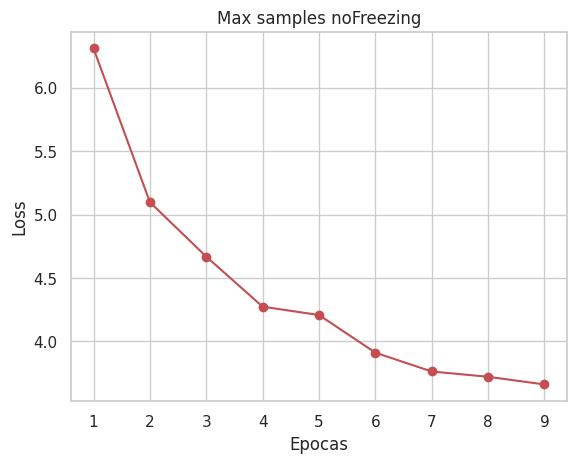

In [56]:
#@title Grafica Loss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Estilo general

m = metrics.copy()
x = np.arange(1, 10)
y = []

for metric in m:
  y.append(metric['loss'])

plt.plot(x, y, '-or'); plt.title('Max samples noFreezing'); plt.xlabel('Epocas'); plt.ylabel('Loss')